## Concat Historical GDP data and GDP from FRED

##### By Hang Miao

##### For class use only, non transferable

In this notebook I will use python to perform three tasks. 
<br>
<br>
The first one is merging the historical data with the data pulled from FRED. The reason we want to do that is because Bureau of Economics Analysis(BEA) only provide the GDP data starting from 1930 and some of the data before 1960 is incomplete. That is why we see a lot NaN(missing or unavailable data) before 1960s. Fortunately, renowned historian Economists like [Michael Bordo]( https://sites.google.com/site/michaelbordo/ "click to go to the detailted describtion") and [Hugh Rockoff]( http://econweb.rutgers.edu/rockoff/ "click to go to the detailted describtion") synthesize the previous estimated historical data so we could combine their synthesized historical data with the latest data that we fetched from FRED together. As a result we have a much longer range of annual data from 1880-2018 instead of 1950 - 2018. 
<br>
<br>
The second one is providing two different method to compute the growth rate of the GDP. These are 'Percentage change method' and 'log difference method'. The 'Percentage change method' is derived directly from the growth rate definition: $ r_t = \frac{GDP_{t+1}-GDP_t }{GDP_t}$. The log difference method' is an estimation of growth rate where $ r_t = log(GDP_{t+1}) - log(GDP_{t}) $. In class I will show you the proof why these two method are equivalent under the condition that $GDP_{t+1}$ is not deviate too far from $GDP_t$. From the plot we see the two growth series coincide with each other except in the period of Great depression (nevertheless, even in such extreme case 'Log Difference' method is still a good estimation of the growth rate). 
<br>
<br>
The third one is obtaining the summary statistics of growth rate series. i.e the mean, variance, max, min and the quantiles.

In [5]:
import pandas as pd
import numpy as np
from math import sqrt
from math import log

In [2]:
print(np.__version__)
print(pd.__version__)

1.17.2
0.25.1


In [6]:
#setting for 
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
figsize(20, 5)

In [7]:
from fredapi import Fred
fred = Fred(api_key='6454787ee0ad3d515189b1ff353020f2')

#### Clean Historical US GDP data from [Michael Bordo]( https://sites.google.com/site/michaelbordo/ "click to go to the detailted describtion") 's Historical data excel file.
[Data Source]( https://sites.google.com/site/michaelbordo/home4 "click to go to the detailted describtion") 

<br>
Please put the excel file 'allc1880n2.xls' into the same folder where this notebook located.

In [10]:

#'allc1880n2.xls' contains several countries historical data, 
# it has three levels of indices which are Country id, Country name, and Year
# pd.read_excel: read excel historical data file from 'allc1880n2.xls', and convert to dataframe. 
# 'header= ' tells python which rows are the column names not data itself
# 'index_col= ' tells python which columns are index not data itself

Macro_histo = pd.read_excel('allc1880n2.xls',sheet_name='updated',
                            header=[0],index_col = [0,1,2] )

In [11]:
Macro_histo.tail(5)

nGDP   gsugdp     infl rgdpNEW   rgdpgr tot  \
id Country  Year                                                       
56 ZIMBABWE 1993  42481000000 -9.11937  27.5961     NaN  2.96354   .   
            1994  55779800000        .  22.2572     NaN  5.95474   .   
            1995  61393400000        .  22.5941     NaN -2.32685   .   
            1996  84785600000        .    21.43     NaN  7.75165   .   
            1997            .        .  18.7433     NaN  4.40167   .   

                      totch   trbgdp  debtgdp     monagglc  ... Depfrz forbA  \
id Country  Year                                            ...                
56 ZIMBABWE 1993    -2.9494 -1.89086  21.3531   6258600000  ...      .     .   
            1994 -0.0198629 -6.39119        .   7396000000  ...      .     .   
            1995  -0.665541        .        .  11269800000  ...      .     .   
            1996       0.13        .        .  13874500000  ...      .     .   
            1997  -0.552282        .        .  21319900000  ...      .     .   

                 forbB forbC PubAMC PDRP BankStr UBI ubin Branch  
id Country  Year                                                  
56 ZIMBABWE 1993     .     .      .    .       .   1    1      .  
            1994     .     .      .    .       .   1    1      .  
            1995     .     .      .    .       .   1    1      .  
            1996     .     .      .    .       .   1    1      .  
            1997     .     .      .    .       .   1    1      .  

[5 rows x 79 columns]

In [12]:
# list the index item in first level: country id
print(Macro_histo.index.levels[0])
# list the index item in second level: country
print(Macro_histo.index.levels[1])
# list the index item in third level: year
print(Macro_histo.index.levels[2])

Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
            35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
            52, 53, 54, 55, 56],
           dtype='int64', name='id')
Index(['Argentina', 'Australia', 'Austria', 'Bangladesh', 'Belgium', 'Brazil',
       'COLOMBIA', 'COSTA RICA', 'COTE D'IVOIRE', 'Canada', 'Chile', 'China',
       'Denmark', 'ECUADOR', 'EGYPT', 'Finland', 'France', 'GHANA', 'Germany',
       'Greece', 'HONG KONG', 'ICELAND', 'INDIA', 'INDONESIA', 'IRELAND',
       'ISRAEL', 'Italy', 'JAMAICA', 'Japan', 'KOREA', 'MALAYSIA', 'MEXICO',
       'NEW ZEALAND', 'NIGERIA', 'Netherlands', 'Norway', 'PAKISTAN',
       'PARAGUAY', 'PERU', 'PHILIPPINES', 'Portugal', 'SENEGAL', 'SINGAPORE',
       'SOUTH AFRICA', 'SRI LANKA', 'Spain', 'Sweden', 'Switzerland', 'TAIWAN',
       'THAILAND', 'TURKEY', 'URUGUAY', 'United Kingdom', 'United States',


In [13]:
#make a inquiry for the data which country equals 'Unitied States' 
#and store the data into the variable named 'Macro_histo_USA'
Macro_histo_USA = Macro_histo[Macro_histo.index.get_level_values('Country') == 'United States']
Macro_histo_USA.head(5)

nGDP    gsugdp     infl rgdpNEW   rgdpgr    tot  \
id Country       Year                                                           
53 United States 1880  10150000000  0.650246        .     NaN -77.8595   89.7   
                 1881  11270000000  0.887311        0     NaN  11.0345   96.4   
                 1882  12160000000   1.20066        0     NaN  7.89707   98.8   
                 1883  11550000000   1.15152 -3.44828     NaN -1.62418   99.6   
                 1884  10970000000  0.957156 -3.57143     NaN -1.50393  102.3   

                          totch    trbgdp debtgdp    monagglc  ... Depfrz  \
id Country       Year                                          ...          
53 United States 1880         .   2.55764       .  2760000000  ...      .   
                 1881   7.46934  0.229814       .  3310000000  ...      .   
                 1882   2.48963  0.828947       .  3570000000  ...      .   
                 1883  0.809717  0.628571       .  3790000000  ...      .   
                 1884   2.71084   1.49954       .  3790000000  ...      .   

                      forbA forbB forbC PubAMC PDRP BankStr UBI ubin Branch  
id Country       Year                                                        
53 United States 1880     .     .     .      .    .       .   3    3      0  
                 1881     .     .     .      .    .       .   3    3      0  
                 1882     .     .     .      .    .       .   3    3      0  
                 1883     .     .     .      .    .       .   3    3      0  
                 1884     .     .     .      .    .       .   3    3      0  

[5 rows x 79 columns]

In [14]:
histo_GDP = Macro_histo_USA['nGDP'].copy()
histo_GDP.reset_index(level=['id','Country'], drop = True, inplace = True)
#histo_GDP.reset_index(level= 'Year',  inplace = True)
#histo_GDP['time'] = pd.to_datetime(histo_GDP.index.levels[2])
print(type(histo_GDP))
histo_GDP.head(4)

<class 'pandas.core.series.Series'>


Year
1880    10150000000
1881    11270000000
1882    12160000000
1883    11550000000
Name: nGDP, dtype: object

In [15]:
#measured in billion
histo_GDP =histo_GDP/1000000000

In [16]:
histo_GDP.head(4)

Year
1880    10.15
1881    11.27
1882    12.16
1883    11.55
Name: nGDP, dtype: object

In [17]:
#transform 
df_histo_GDP = pd.DataFrame(histo_GDP)
df_histo_GDP.tail(4)

,nGDP
Year,
1994,6722.9
1995,7033.6
1996,7390.6
1997,7823.3


In [18]:
#transform the string type of the original index/column 'Year' to a datetime object 
import datetime
df_histo_GDP['Time'] = pd.to_datetime(df_histo_GDP.index,format='%Y')
df_histo_GDP.index = df_histo_GDP['Time'] 
del df_histo_GDP['Time']
#del df_histo_GDP['time']

In [19]:
df_histo_GDP.tail(4)

,nGDP
Time,
1994-01-01,6722.9
1995-01-01,7033.6
1996-01-01,7390.6
1997-01-01,7823.3


#### Pull the latest GNP GDP from FRED

In [20]:
#GNP with quarterly frequency
GNP_Quarter = fred.get_series('GNP')
#GNP with annually frequency
GNP_Annual = fred.get_series('GNPA')
#GDP with quarterly frequency
GDP_Quarter = fred.get_series('GDP')
#GDP with annually frequency
GDP_Annual = fred.get_series('GDPA')

Real_GDP_Quarter = fred.get_series('GDPC1')
Real_GDP_Annual = fred.get_series('GDPCA')

#GDP Deflator
GDPDEF_Quarterly = fred.get_series('GDPDEF')

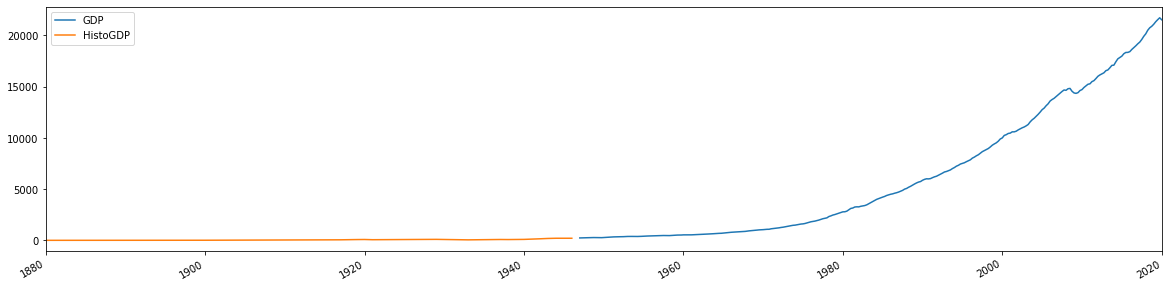

In [21]:
df = {}

df['GDP'] = GDP_Quarter
df['HistoGDP'] = df_histo_GDP['nGDP']
df = pd.DataFrame(df)
df.plot()


In [24]:
# Transform the Quarter frequency series GDP_Quarter to a annual frequency curve
df_Annual = df.groupby(pd.Grouper(freq='YS')).nth(0) #year start, Y stands for year end


In [25]:
df_Annual.head(5)

,GDP,HistoGDP
1880-01-01,NaN,10.15
1881-01-01,NaN,11.27
1882-01-01,NaN,12.16
1883-01-01,NaN,11.55
1884-01-01,NaN,10.97


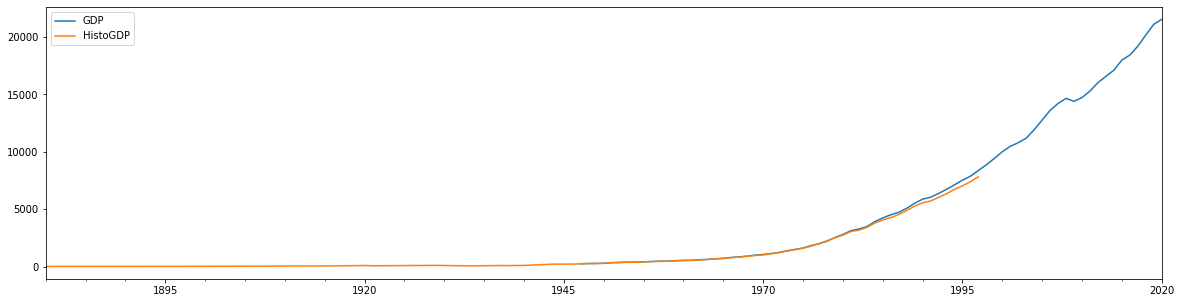

In [26]:
df_Annual.plot()

In [27]:
df_Annual.to_csv('histo_GDP')

In [28]:
df_Annual[df_Annual['GDP'].notna()].head(5)

,GDP,HistoGDP
1947-01-01,243.164,235.2
1948-01-01,265.742,261.6
1949-01-01,275.034,260.4
1950-01-01,280.828,288.3
1951-01-01,336.000,333.4


#### Merging the two series 'GDP' and 'HistoGDP' into 'GDPconcat'

In [29]:
# form a new annually GDP series from concating the histo_GDP(1880-01-01:1946-01-01)
# and GDP (1947-01-01: the latest release)
df1 = df_Annual['HistoGDP'].loc['1880-01-01':'1946-01-01']
df2 = df_Annual['GDP'].loc['1947-01-01':]
df_Annual['GDPconcat'] = pd.concat([df1,df2])

In [30]:
df_Annual.tail(5)

,GDP,HistoGDP,GDPconcat
2016-01-01,18424.283,NaN,18424.3
2017-01-01,19190.431,NaN,19190.4
2018-01-01,20163.159,NaN,20163.2
2019-01-01,21098.827,NaN,21098.8
2020-01-01,21534.907,NaN,21534.9


In [31]:
df_Annual.head(5)

,GDP,HistoGDP,GDPconcat
1880-01-01,NaN,10.15,10.15
1881-01-01,NaN,11.27,11.27
1882-01-01,NaN,12.16,12.16
1883-01-01,NaN,11.55,11.55
1884-01-01,NaN,10.97,10.97


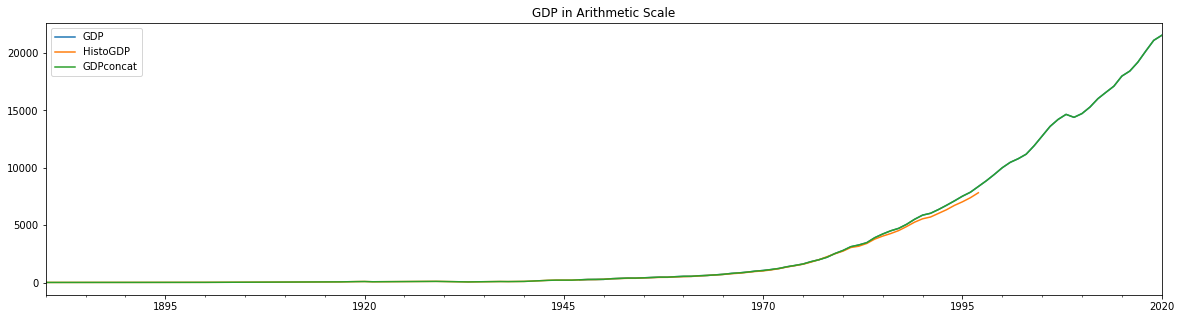

In [32]:
df_Annual.plot( title = 'GDP in Arithmetic Scale')


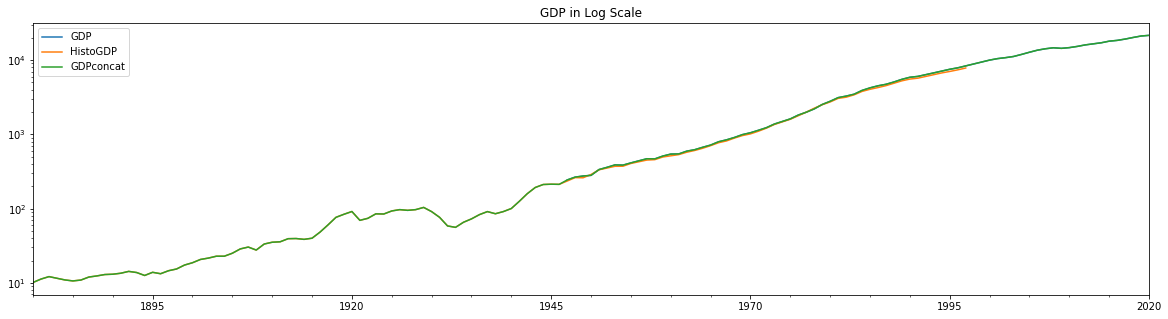

In [41]:
#log scale
df_Annual.plot(logy = True, title = 'GDP in Log Scale')

#### Growth Rate

In [42]:
#claim an empty dictionary called dict_Annual_return
dict_Annual_return={}
# First Method: Growth rate by percent change
dict_Annual_return['pct_change'] = df_Annual['GDPconcat'].pct_change()
# Second Method: Growth rate by log difference
dict_Annual_return['log_diff'] = np.log(df_Annual['GDPconcat'].astype('float64'))-np.log(df_Annual['GDPconcat'].astype('float64')).shift(1)

# convert the dictionary to a dataframe
df_Annual_return = pd.DataFrame(dict_Annual_return)


In [43]:
df_Annual_return.head(5)

,pct_change,log_diff
1880-01-01,NaN,NaN
1881-01-01,0.110345,0.104671
1882-01-01,0.078971,0.076008
1883-01-01,-0.050164,-0.051466
1884-01-01,-0.050216,-0.051521


In [44]:
df_Annual_return.tail(5)

,pct_change,log_diff
2016-01-01,0.024472,0.024177
2017-01-01,0.041584,0.040742
2018-01-01,0.050688,0.049445
2019-01-01,0.046405,0.045360
2020-01-01,0.020668,0.020458


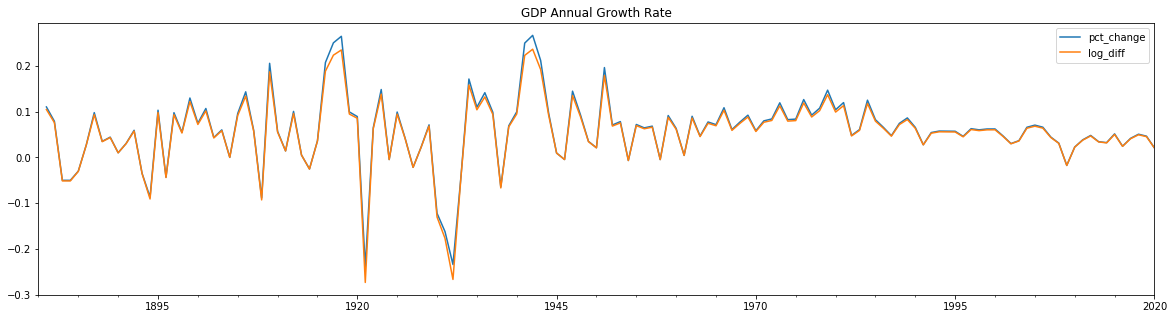

In [45]:
# Plot and save the figure as 'GDP_GROWTH_RATE.png'. 
fig = df_Annual_return.plot(title = 'GDP Annual Growth Rate').get_figure()
fig.savefig('GDP_GROWTH_RATE.png')  #You could change the name of '.png' file you like

### Obtain the summary statistics of the time series

In [46]:
df_Annual_return.describe()

,pct_change,log_diff
count,140.000000,140.000000
mean,0.059077,0.054714
std,0.076123,0.074527
min,-0.239344,-0.273574
25%,0.030989,0.030519
50%,0.061495,0.059678
75%,0.093656,0.089525
max,0.266932,0.236598


#### Save the GDP Growth Rate data file to the same location as this notebook on hard drive

In [47]:
df_Annual_return.to_csv('GDP_Growth_Rate.csv') # you could change name of the '.csv' file you like
# .csv is a simplified excel format, you could open such file by excel by default.

#### Save the merged GDP  data file to the same location as this notebook on hard drive

In [48]:
df_Annual.to_csv('Merged_GDP.csv')

#### Read the 'GDP_Growth_Rate.csv' from the hard drive

In [49]:
#read
Read_df_Annual_return = pd.read_csv('GDP_Growth_Rate.csv', index_col = 0, header = 0)
#show the first 5 rows
Read_df_Annual_return.head(5) 

,pct_change,log_diff
1880-01-01,NaN,NaN
1881-01-01,0.110345,0.104671
1882-01-01,0.078971,0.076008
1883-01-01,-0.050164,-0.051466
1884-01-01,-0.050216,-0.051521


#### Read the 'Merged_GDP.csv' from the hard drive

In [50]:
#read
Read_df_Annual = pd.read_csv('Merged_GDP.csv', index_col = 0, header = 0)
#show the first 5 rows
Read_df_Annual.head(5) 

,GDP,HistoGDP,GDPconcat
1880-01-01,NaN,10.15,10.15
1881-01-01,NaN,11.27,11.27
1882-01-01,NaN,12.16,12.16
1883-01-01,NaN,11.55,11.55
1884-01-01,NaN,10.97,10.97
